In [3]:
from transformers import GPT2LMHeadModel
device = 'cpu'

/Users/joshuagao/miniconda3/envs/gpt-nano/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [5]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

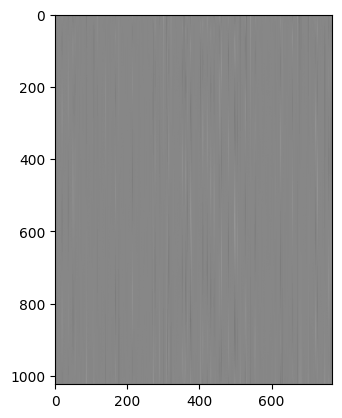

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

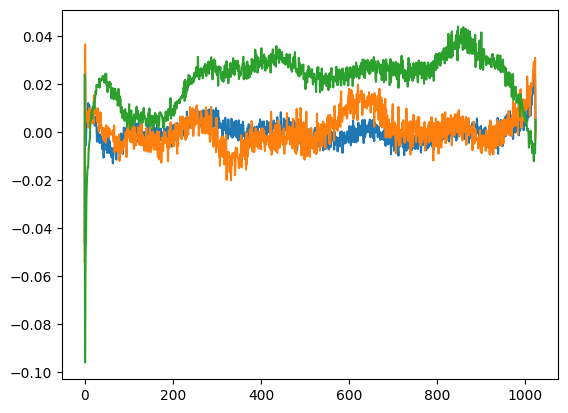

In [7]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

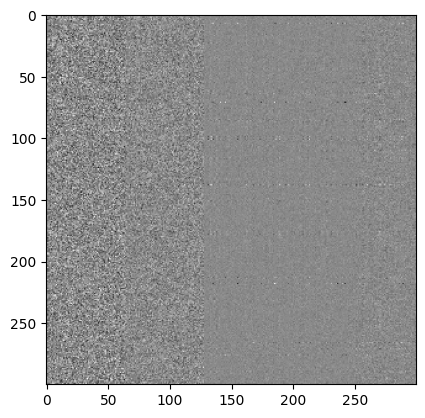

In [8]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

In [9]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, I'm writing a new language for you. But first, I'd like to tell you about the language itself"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to be as expressive as possible. In order to be expressive, it is necessary to know"},
 {'generated_text': "Hello, I'm a language model, so I don't get much of a license anymore, but I'm probably more familiar with other languages on that"},
 {'generated_text': "Hello, I'm a language model, a functional model... It's not me, it's me!\n\nI won't bore you with how"},
 {'generated_text': "Hello, I'm a language model, not an object model.\n\nIn a nutshell, I need to give language model a set of properties that"}]

In [35]:
# let's instead sample manually
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
x = tokens.to(device)

# generate!
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, and I can't understand my language. So I'd just give a different language in the middle of my school
> Hello, I'm a language model, but there are times when I think of 'machine.
- The idea is to make systems by the code
> Hello, I'm a language model, and you know it is one thing. But that's not as simple as you might think or need to be
> Hello, I'm a language model, and in this course, I'll be working with an example where I do things like:
In this course
> Hello, I'm a language model, but I don't have a lot of training experience in other languages. I can tell you which language I should


In [11]:
# tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [12]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [13]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [14]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [15]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

tensor(True)

In [16]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

12884901888
12884901888


In [17]:

# standard deviation grows inside the residual stream
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += n**-0.5 * torch.randn(768)

print(x.std())

tensor(1.0349)


In [18]:
import torch

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is (due to readuction='mean')
# L = 1/4 * [
#            (y[0] - yhat[0])**2 +
#            (y[1] - yhat[1])**2 +
#            (y[2] - yhat[2])**2 +
#            (y[3] - yhat[3])**2
#           ]
# NOTE: 1/4!

tensor([ 0.1214,  0.0466, -0.0105, -0.0659, -0.0189,  0.0101,  0.0366,  0.1062,
         0.1457, -0.0130])


In [19]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = 1/4(y[0] - yhat[0])**2
# L1 = 1/4(y[1] - yhat[1])**2
# L2 = 1/4(y[2] - yhat[2])**2
# L3 = 1/4(y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4 # <-- have to add back the "normalizer"!
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])


tensor([ 0.1214,  0.0466, -0.0105, -0.0659, -0.0189,  0.0101,  0.0366,  0.1062,
         0.1457, -0.0130])


Min Train Loss: 0.015217
Min Validation Loss: 3.0873
Max Hellaswag eval: 0.3164


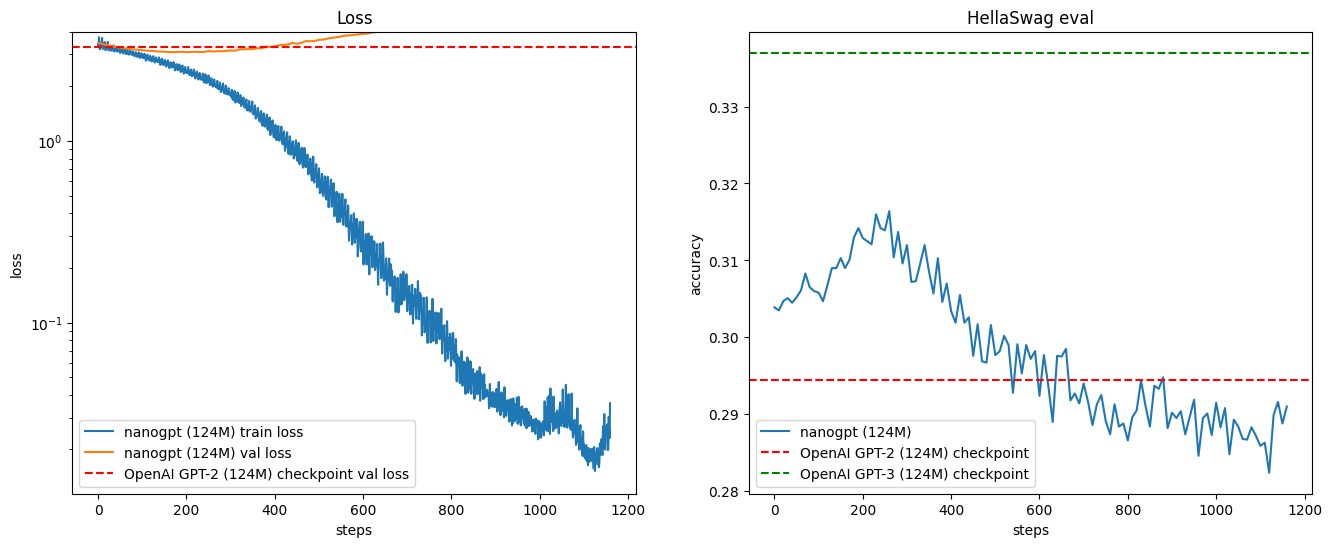

In [5]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
    "350M": 3.2924
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/civil_finetune_v3_logs.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=10.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))